In [38]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
np.random.seed(42)

In [39]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**From the above output, we can conclude and note that:**

* There are missing values in income
* Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
* There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later. 

First of all, for the missing values, I am going to replace them with mean

In [41]:
# Imputing missing values with mean
data.loc[(data['Income'].isnull() == True), 'Income'] = data['Income'].mean()   

In [44]:
data["Dt_Customer"]

0       04-09-2012
1       08-03-2014
2       21-08-2013
3       10-02-2014
4       19-01-2014
           ...    
2235    13-06-2013
2236    10-06-2014
2237    25-01-2014
2238    24-01-2014
2239    15-10-2012
Name: Dt_Customer, Length: 2240, dtype: object

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [46]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y', dayfirst=True)
data['Dt_Customer']

0      2012-09-04
1      2014-03-08
2      2013-08-21
3      2014-02-10
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-06-10
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2240, dtype: datetime64[ns]

In [48]:
# Tìm ngày gần nhất (ngày mới nhất) trong cột 'Dt_Customer'
latest_date = data['Dt_Customer'].max()

# In ra kết quả
print(latest_date)


2014-06-29 00:00:00


In the next step, I am going to create a feature out of **"Dt_Customer"** that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record. 
Thus to get the values I must check the newest and oldest recorded dates. 

Dữ liệu được thu thập vào ngày 1-1-2015

In [47]:
# Chuyển đổi cột Dt_Customer sang định dạng datetime với định dạng ngày/tháng/năm
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y', dayfirst=True)

# Tạo cột Date_Collected (giả định dữ liệu được thu thập vào ngày 01-01-2015)
data['Date_Collected'] = '01-01-2015'
data['Date_Collected'] = pd.to_datetime(data['Date_Collected'], format='%d-%m-%Y')

# Tính thời gian khách hàng đã đăng ký (số ngày)
data['Time_Enrolled_Days'] = (data['Date_Collected'] - data['Dt_Customer']).dt.days

# Hiển thị một phần dữ liệu để kiểm tra
data[['Dt_Customer', 'Date_Collected', 'Time_Enrolled_Days']].head()


,Dt_Customer,Date_Collected,Time_Enrolled_Days
0,2012-09-04,2015-01-01,849
1,2014-03-08,2015-01-01,299
2,2013-08-21,2015-01-01,498
3,2014-02-10,2015-01-01,325
4,2014-01-19,2015-01-01,347


In [8]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Date_Collected,Time_Enrolled_Days
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,3,11,1,2015-01-01,849
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,3,11,0,2015-01-01,299
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,3,11,0,2015-01-01,498
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,3,11,0,2015-01-01,325
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,3,11,0,2015-01-01,347


In [9]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Date_Collected', 'Time_Enrolled_Days'],
      dtype='object')

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.  

In [10]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


**In the next bit, I will be performing the following steps to engineer some new features:**

* Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
* Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
* Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, Creating feature indicating **"Family_Size"**
* Create a feature **"Is_Parent"** to indicate parenthood status
* Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
* Dropping some of the redundant features

In [11]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2015-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})



C:\Users\Admin\AppData\Local\Temp\ipykernel_11724\2031141493.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


In [12]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,...,Z_Revenue,Response,Date_Collected,Time_Enrolled_Days,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,11,1,2015-01-01,849,58,1617,Alone,0,1,0
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,11,0,2015-01-01,299,61,27,Alone,2,3,1
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,11,0,2015-01-01,498,50,776,Partner,0,2,0
3,6182,1984,Graduate,Together,26646.0,1,0,2014-02-10,26,11,...,11,0,2015-01-01,325,31,53,Partner,1,3,1
4,5324,1981,Postgraduate,Married,58293.0,1,0,2014-01-19,94,173,...,11,0,2015-01-01,347,34,422,Partner,1,3,1


In [13]:
#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID","Date_Collected"]
data = data.drop(to_drop, axis=1)

In [14]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Time_Enrolled_Days,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,849,58,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,299,61,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,498,50,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,325,31,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,347,34,422,Partner,1,3,1


In [16]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Time_Enrolled_Days,Age,Spent,Children,Family_Size,Is_Parent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,...,0.064286,0.013393,0.009375,0.149107,539.582143,46.194196,605.798214,0.950446,2.595089,0.715179
std,25037.797168,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,...,0.245316,0.114976,0.096391,0.356274,202.122512,11.984069,602.249288,0.751803,0.906959,0.451430
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,186.000000,19.000000,5.000000,0.000000,1.000000,0.000000
25%,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,366.750000,38.000000,68.750000,0.000000,2.000000,0.000000
50%,51741.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,541.500000,45.000000,396.000000,1.000000,3.000000,1.000000
75%,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,715.000000,56.000000,1045.500000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,...,1.000000,1.000000,1.000000,1.000000,885.000000,122.000000,2525.000000,3.000000,5.000000,1.000000


The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that  max-age is 128 years, As I calculated the age that would be today (i.e. 2021) and the data is old.

It clearly says there are outliers in Income and age, taking only those data points which falls under 3 standard deviation.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

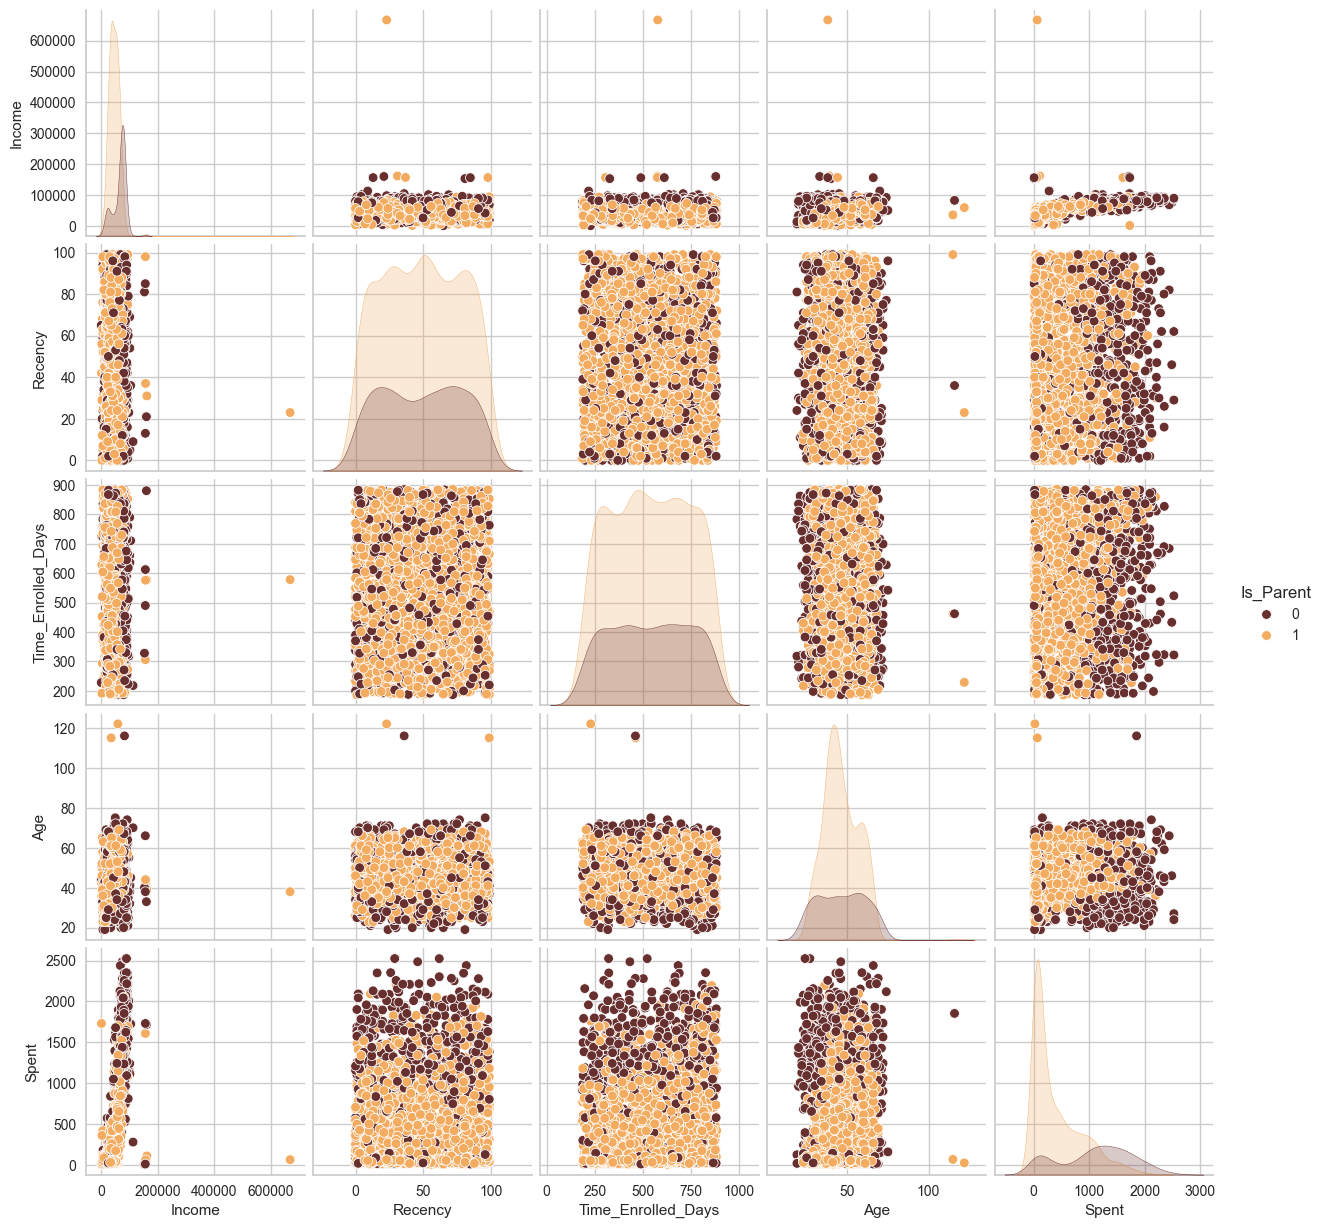

In [17]:
#Plotting following features
To_Plot = [ "Income", "Recency", "Time_Enrolled_Days", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Clearly, there are a few outliers in the Income and Age features. 
I will be deleting the outliers in the data. 

In [18]:
# Removing outliers in income
from scipy import stats

data = data[(np.abs(stats.zscore(data['Income'])) < 3)]     # Remove observation with more than 3 in Standard Desviation
data.reset_index(inplace=True)                          # Reset index
data = data.drop(columns=['index'])   

In [19]:
data.shape

(2232, 30)

In [20]:
sns.heatmap(data.corr())

ValueError: could not convert string to float: 'Graduate'

The data is quite clean and the new features have been included. I will proceed to the next step. That is, preprocessing the data. 


## Data preprocessing

In [21]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [22]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [23]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Time_Enrolled_Days,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,849,58,1617,0,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,299,61,27,0,2,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,498,50,776,1,0,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,325,31,53,1,1,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,347,34,422,1,1,3,1


In [24]:
data_final = data.copy()

#Scaling
scaler = StandardScaler()
scaler.fit(data_final)
scaled_ds = pd.DataFrame(scaler.transform(data_final),columns= data_final.columns )
print("All features are now scaled")

All features are now scaled


In [25]:
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Time_Enrolled_Days,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.894106,0.315469,-0.825420,-0.931339,0.307081,0.980281,1.547741,1.735476,2.457243,1.472657,...,-0.116722,-0.097458,2.383828,1.530417,0.983726,1.682002,-1.344451,-1.266161,-1.759248,-1.587610
1,-0.894106,-0.257134,1.031775,0.905012,-0.383851,-0.872949,-0.637496,-0.726318,-0.651911,-0.633057,...,-0.116722,-0.097458,-0.419493,-1.189828,1.233983,-0.962227,-1.344451,1.394923,0.446111,0.629878
2,-0.894106,0.969686,-0.825420,-0.931339,-0.798410,0.359568,0.568152,-0.174694,1.341605,-0.148984,...,-0.116722,-0.097458,-0.419493,-0.205594,0.316372,0.283388,0.743798,-1.266161,-0.656569,-1.587610
3,-0.894106,-1.213481,1.031775,-0.931339,-0.798410,-0.872949,-0.562143,-0.662493,-0.505598,-0.584649,...,-0.116722,-0.097458,-0.419493,-1.061234,-1.268592,-0.918988,0.743798,0.064381,0.446111,0.629878
4,0.567905,0.322994,1.031775,-0.931339,1.550759,-0.391822,0.417446,-0.215724,0.152811,-0.003763,...,-0.116722,-0.097458,-0.419493,-0.952424,-1.018334,-0.305328,0.743798,0.064381,0.446111,0.629878


## Perform Clustering


**Steps involved in the Clustering**
* Elbow Method to determine the number of clusters to be formed
* Model evaluation using Silhouette score

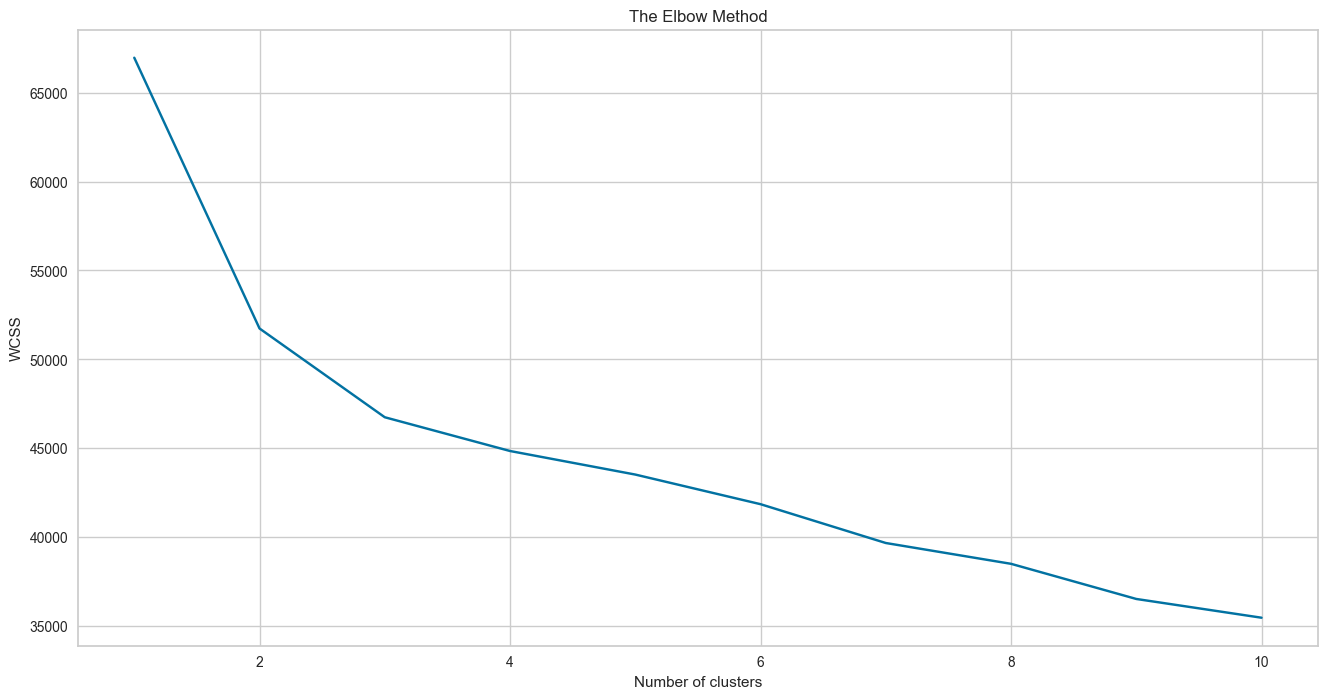

In [26]:
from sklearn.cluster import KMeans
wcss=[]
for i in range (1,11):
 kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans.fit(scaled_ds)
 wcss.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(range(1,11),wcss, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From above graph we can choose number of clusters as 4. Lets see for silhouette score for more details.

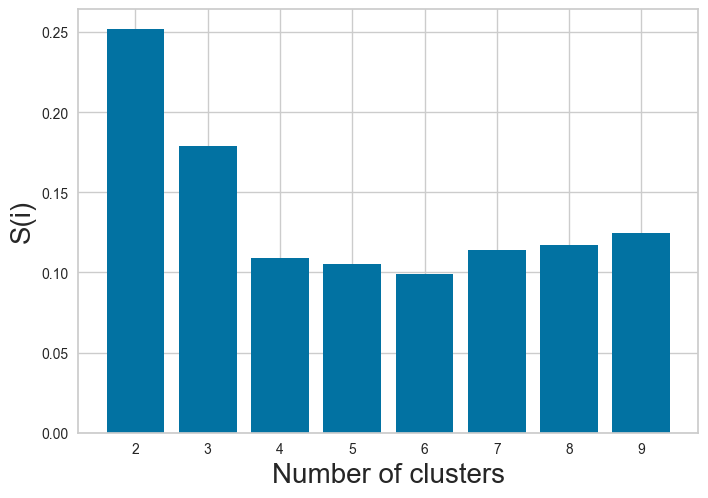

In [27]:
from sklearn.metrics import silhouette_score 
silhouette_scores = []
for i in range(2,10):
    m1=KMeans(n_clusters=i, random_state=42)
    c = m1.fit_predict(scaled_ds)
    silhouette_scores.append(silhouette_score(scaled_ds, m1.fit_predict(scaled_ds))) 
plt.bar(range(2,10), silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

Although score of 3_clusters is higher than 4_clusters, but i am choosing 4 because observations seems to be more evenly distributed among the clusters and making stratgey for 4 cluster is much more convinient.

In [28]:
# Training a predicting using K-Means Algorithm.

kmeans=KMeans(n_clusters=4, random_state=42).fit(scaled_ds)
pred=kmeans.predict(scaled_ds)


# Appending those cluster value into main dataframe (without standard-scalar)

data['cluster'] = pred + 1

In [29]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Time_Enrolled_Days,Age,Spent,Living_With,Children,Family_Size,Is_Parent,cluster
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,1,849,58,1617,0,0,1,0,3
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,299,61,27,0,2,3,1,2
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,498,50,776,1,0,2,0,3
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,325,31,53,1,1,3,1,2
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,347,34,422,1,1,3,1,2


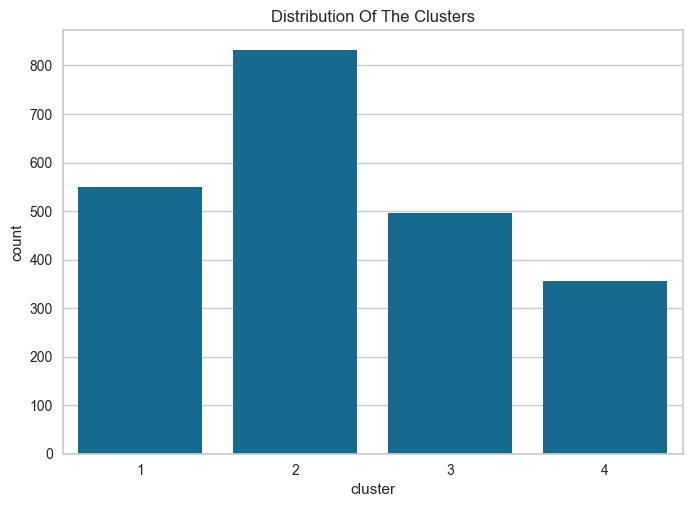

In [30]:
pl = sns.countplot(x=data["cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

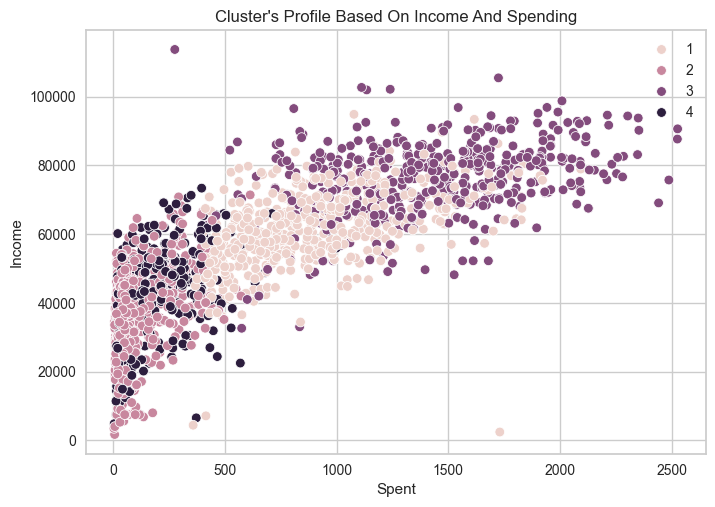

In [31]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["cluster"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs  spending plot shows the clusters pattern**
* group 1: high spending & low income  
* group 2: high spending & high income
* group 3: high spending & average income
* group 4: low spending & low income 

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

C:\Users\Admin\anaconda3\envs\python3_9\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\envs\python3_9\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 74.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\envs\python3_9\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\envs\python3_9\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 28.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\anaconda3\envs\python3_9\lib\

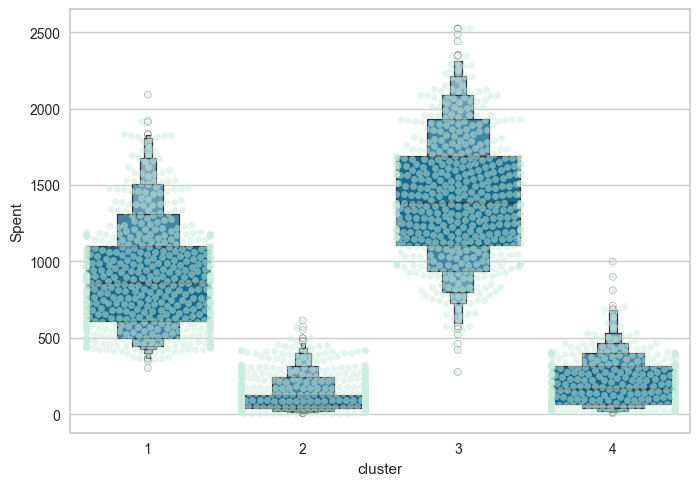

In [32]:
plt.figure()
pl=sns.swarmplot(x=data["cluster"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["cluster"], y=data["Spent"])
plt.show()

From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 1.
We can explore what each cluster is spending on for the targeted marketing strategies.


Let us next explore how did our campaigns do in the past.

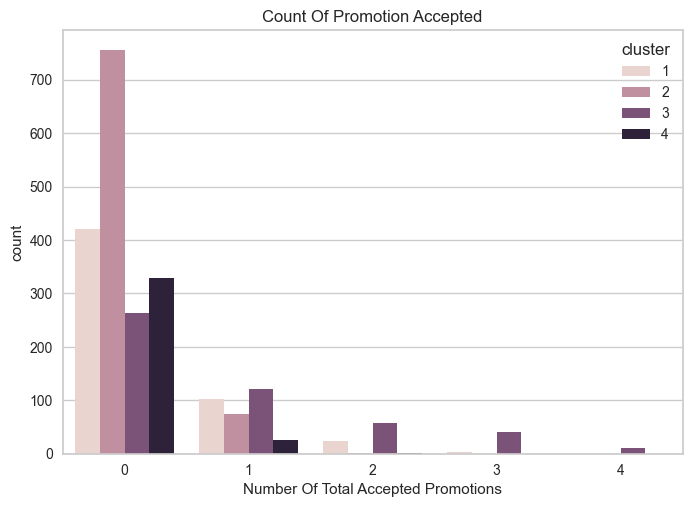

In [33]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["cluster"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one take part in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales. 


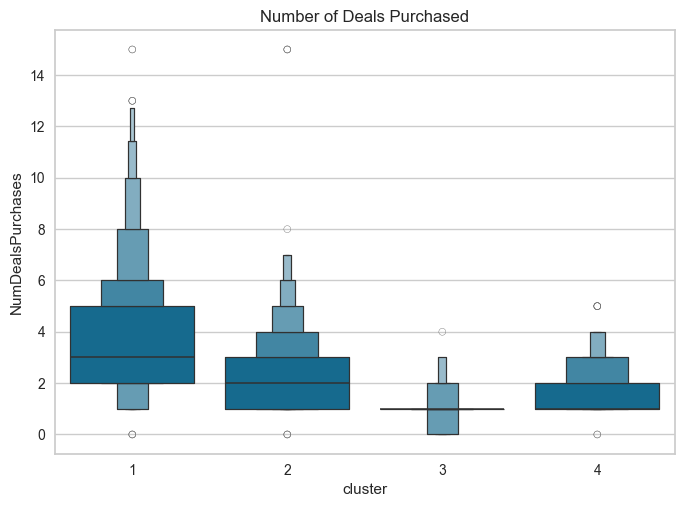

In [34]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["cluster"])
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 1 and cluster 3. 
However, our star customers cluster 2 are not much into the deals. 


<Figure size 800x550 with 0 Axes>

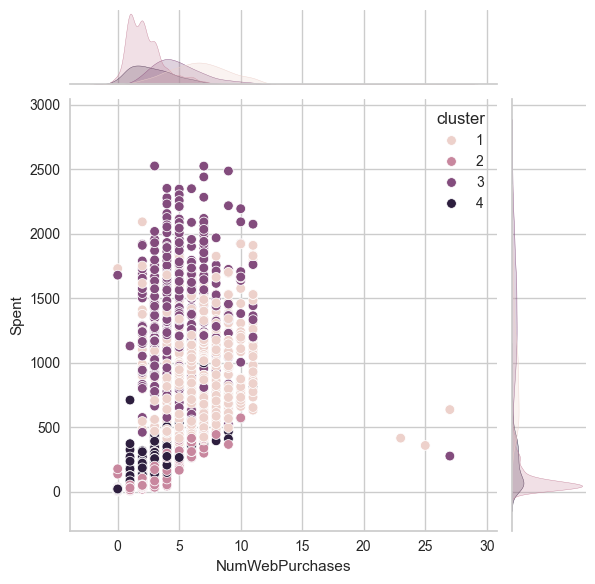

<Figure size 800x550 with 0 Axes>

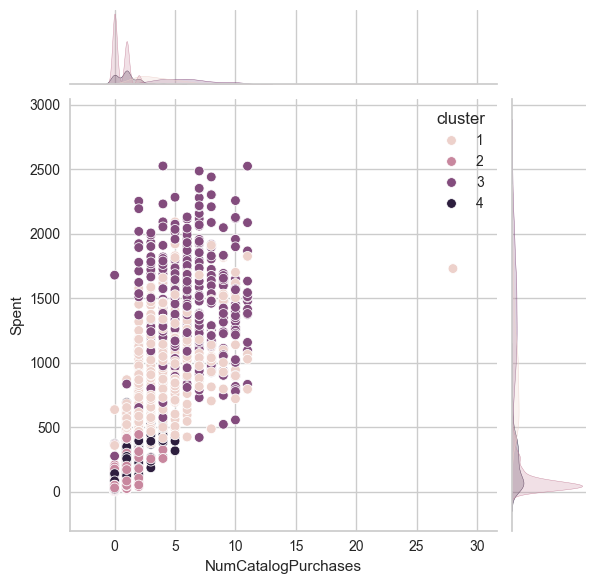

<Figure size 800x550 with 0 Axes>

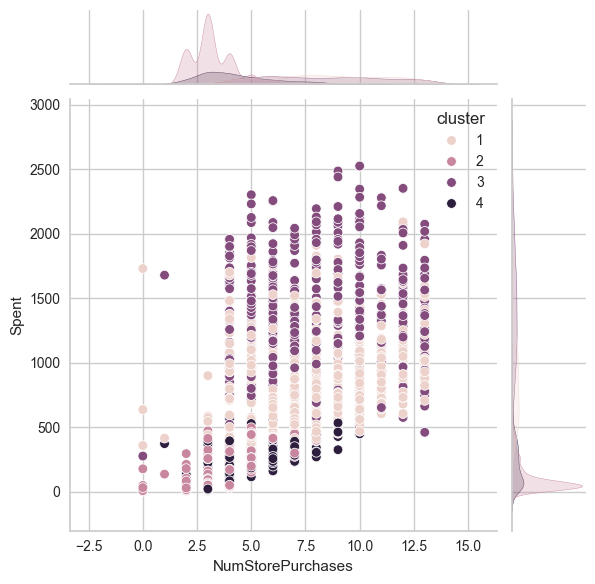

<Figure size 800x550 with 0 Axes>

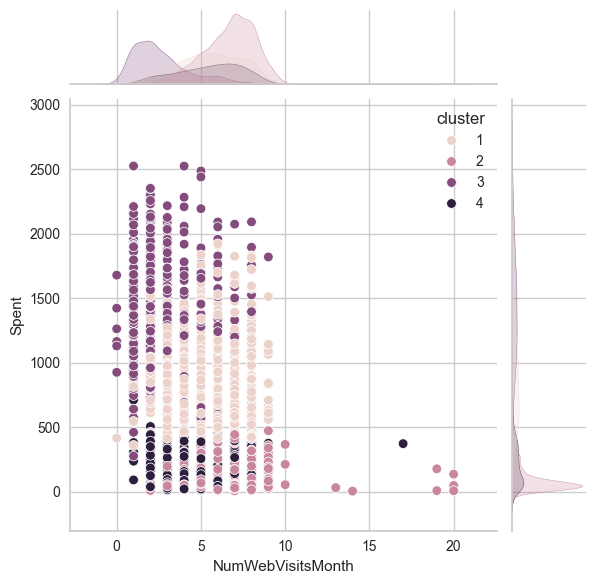

In [35]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x=data[i],y = data["Spent"],hue=data["cluster"])
    plt.show()

## Profiling the clusters

Now that we have formed the clusters and looked at their purchasing habits. 
Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. 
On the basis of the outcomes, I will be arriving at the conclusions. 

<Figure size 800x550 with 0 Axes>

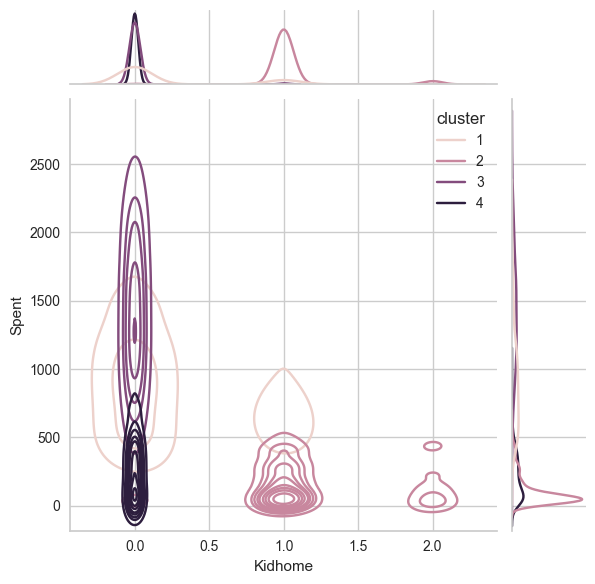

<Figure size 800x550 with 0 Axes>

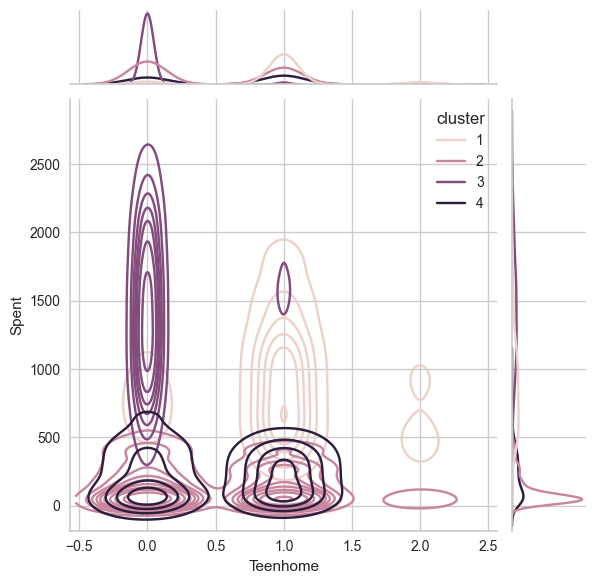

<Figure size 800x550 with 0 Axes>

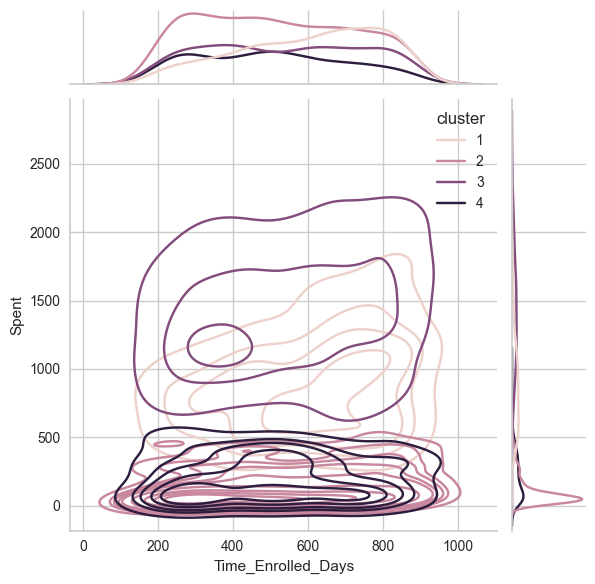

<Figure size 800x550 with 0 Axes>

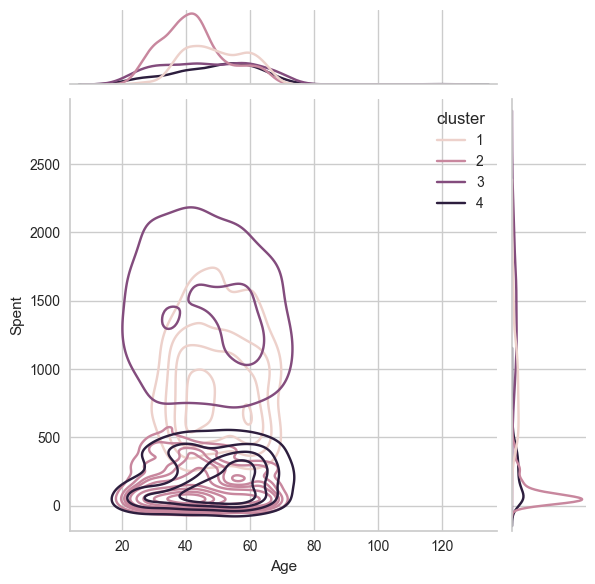

<Figure size 800x550 with 0 Axes>

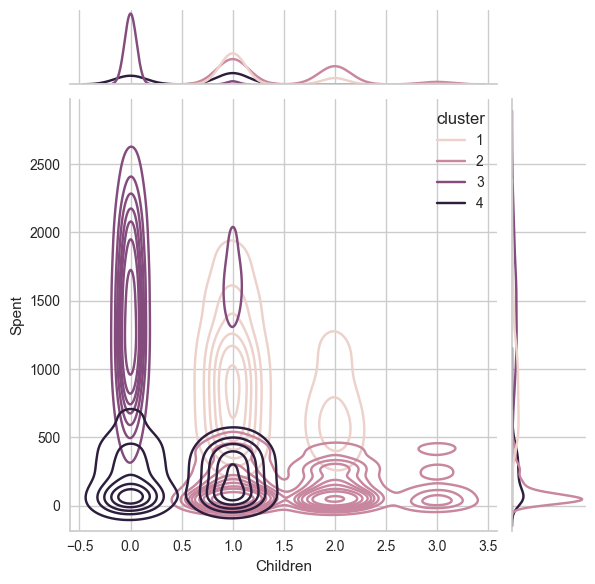

<Figure size 800x550 with 0 Axes>

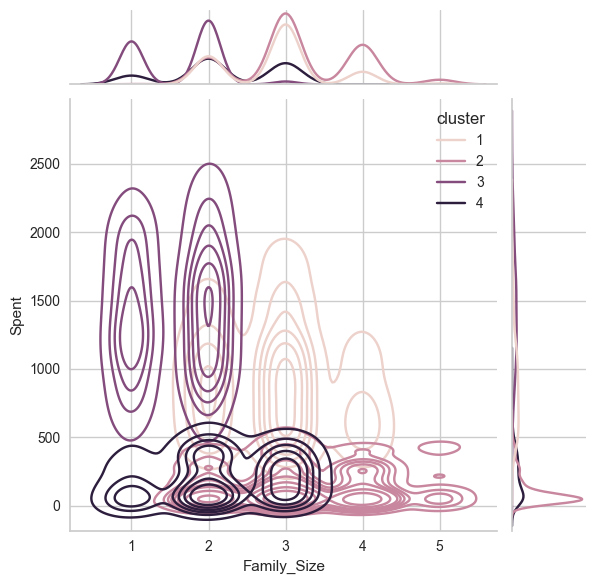

<Figure size 800x550 with 0 Axes>

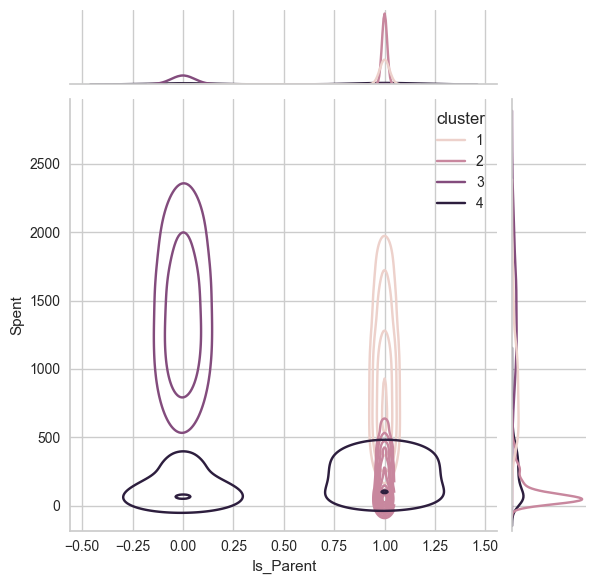

<Figure size 800x550 with 0 Axes>

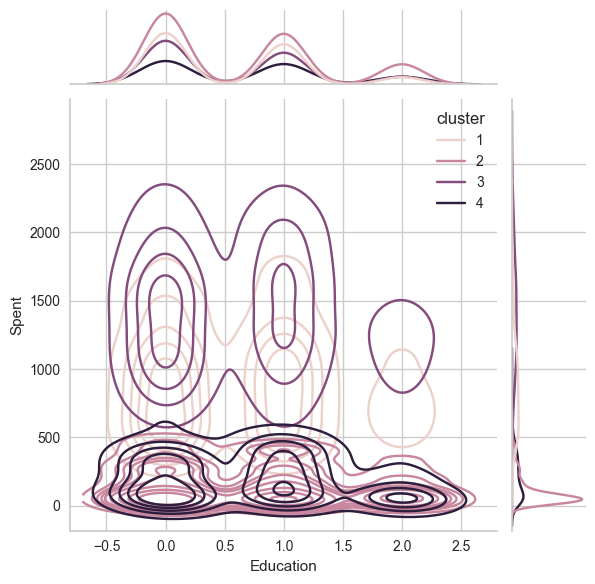

<Figure size 800x550 with 0 Axes>

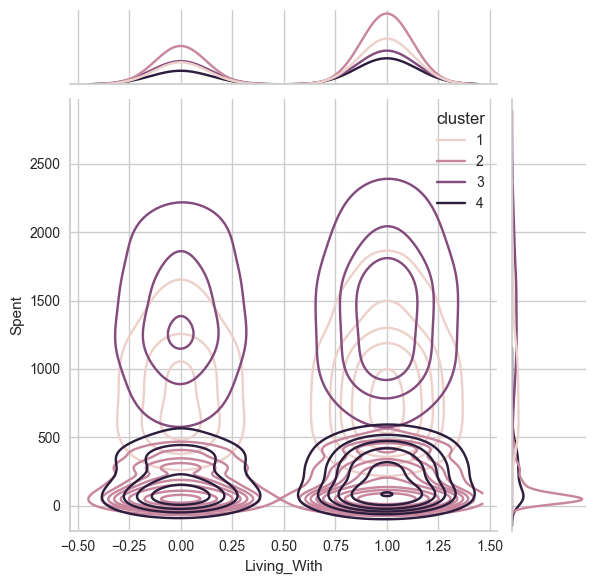

In [36]:
Personal = [ "Kidhome","Teenhome","Time_Enrolled_Days", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["cluster"], kind="kde")
    plt.show()

**Cluster 1 characteristics**:
- They are definitely a parent
- At max there are 5 members in the family and atleast 2
- Majority of them have teenager at home
- Relatively older
- A lower-income group

**Cluster 2 characteristics**
- Are definitely not a parent
- At max there are only 2 members in the family
- A slight majority of couple over single people
- Span all ages
- A high income group

**Cluster 3 characteristics**
- Are definitely a parent
- At max have 4 members in family and atleast 2
- Most have teenager at home
- Relatively older


**Cluster 4 characteristics**
- The majority of these people are parents
- At max there are 3 members in family
- They majorly have one kid
- Relatively younger

In this project, I performed unsupervised clustering. 
I performed K-means clustering and used Elbow curve or Scree-plot to determine the value of K .
I came up with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. 
This can be used in planning better marketing strategies. 